# Loading zipped data

In [1]:
!7z x '/content/data.7z'


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 21744132 bytes (21 MiB)

Extracting archive: /content/iiitd.7z
--
Path = /content/iiitd.7z
Type = 7z
Physical Size = 21744132
Headers Size = 387054
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      4% 570 - iiitd/mnistTask3/mnistTask/0/image_005283.jpg                                                          4% 1198 - iiitd/mnistTask3/mnistTask/0/image_011401.jpg                                                           4% 1619 - iiitd/mnistTask3/

# Importing Libraries

In [150]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import Lambda, Compose, ToTensor
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [151]:
class invert(object):
    def __call__(self, img):
        """
        :param img: (PIL): Image 

        :return: ycbr color space image (PIL)
        """
        img = transforms.functional.invert(img)
        return img

    def __repr__(self):
        return self.__class__.__name__+'()'


```
          :param root_path: path to the data dir, dir: dir with img subfolders, batch_size, phase: return value depends on this, train_val_split=True: default, train_ratio=.8: default

                     :return: data, [train_loader, val_loader] if train_val_split=True and phase='train' else either data, train_loader or data, test_loader
```

In [199]:
def load_data(root_path, dir, batch_size, phase='train', train_val_split=True, train_ratio=.8):
     transform_dict = {
        'train': transforms.Compose(
            [transforms.Grayscale(num_output_channels=1),
            #  invert(),
             transforms.Resize(28), # resized to 28 in accordance with MNIST and for training
             transforms.CenterCrop(28),
            #  transforms.RandomRotation(15), #introduced rotations
             transforms.ToTensor(),
            #  transforms.Normalize((0.0581), (0.1961)), # mean and std dev calculated for given data after invert transform
             ]),
        'test': transforms.Compose(
            [transforms.Resize(28),
             transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,)), # mnist mean and std dev
             ])}
             
     data = datasets.ImageFolder(root=root_path+dir, transform=transform_dict[phase])
     if phase == 'train':
        if train_val_split:
            train_size = int(train_ratio * len(data))
            test_size = len(data) - train_size
            data_train, data_val = torch.utils.data.random_split(data, [train_size, test_size])
            train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, drop_last=True,
                                                    num_workers=2)
            val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size, shuffle=False, drop_last=False,
                                                num_workers=2)
            return data, [train_loader, val_loader]
        else:
            train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True,
                                                    num_workers=2)
            return data, train_loader
     else: 
        test_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False, drop_last=False,
                                                    num_workers=2)
        return data, test_loader

# Data Loading
## MNIST loaded as the test data

In [194]:
test_data = datasets.MNIST(
      root="data",
          train=False,
              download=True,
                  transform=ToTensor(),
                  )
test_dataloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=False, drop_last=False,
                                                    num_workers=2)

### Train loader for `trainPart1`

In [195]:
data, train_dataloader = load_data('/content/iiitd/trainPart1/', 'train', batch_size=64, phase='train', train_val_split=False)

### Train loader for `mnistTask3`

In [200]:
data, train_dataloader = load_data('/content/iiitd/mnistTask3/', 'mnistTask', batch_size=64, phase='train', train_val_split=False)

## For training the first model the mean and standard deviation of the `trainPart1` dataset was calculated for normalization.

In [197]:
mean = 0.
std = 0.
nb_samples = 0.
for data in train_dataloader:
    batch_samples = data[0].size(0)
    data = data[0].view(batch_samples, data[0].size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# Visualizing data after transforms

In [201]:
data

Dataset ImageFolder
    Number of datapoints: 60000
    Root location: /content/iiitd/mnistTask3/mnistTask
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=28, interpolation=bilinear)
               CenterCrop(size=(28, 28))
               ToTensor()
           )

### Plotting the images and corresponding labels

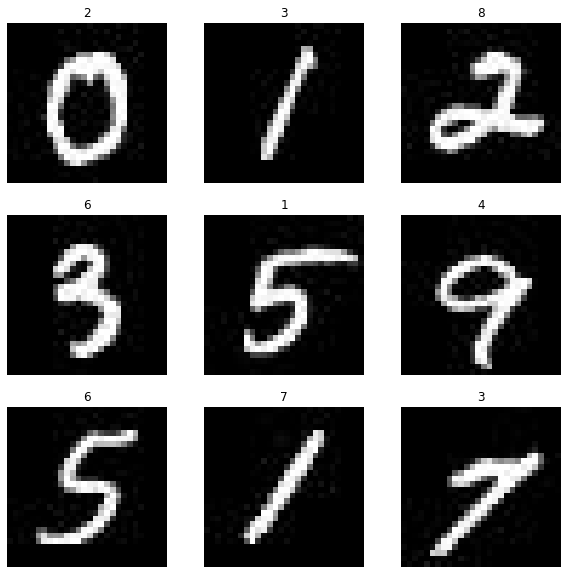

In [202]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(data), size=(1,)).item()
    img, label = data[sample_idx]
    img = img.reshape(28, 28, 1)
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [203]:
for X, y in train_dataloader:
    print('Shape of X: ', X.shape)
    print('Shape of y: ', y.shape)
    break

Shape of X:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64])


In [204]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device.\n')

Using cuda device.



## Convolutional Neural Network with Batch Normalization

The Convolutional Neural Network architecture is LeNet-5 inspired and replaces the `tanh` activation with rectified linear units and also uses batch normalization for the `conv2` and `fc1` layers respectively. For regularization, dropout was also used but as reported in literature it worsened the performance of the convolutional network. After iterating through and trying many models, this was the model that gave the best results.

In [205]:
class ConvNetBN(nn.Module):
    def __init__(self):
        super(ConvNetBN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv2_bn = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(5*5*64, 500)
        self.fc1_bn = nn.BatchNorm1d(500)
        self.fc2 = nn.Linear(500, 62)
        # self.avgpool = nn.AdaptiveAvgPool2d((None, 1))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(self.conv2_bn(x), 2, 2)
        # x = self.avgpool(x)
        x = x.view(-1, 5*5*64)
        x = F.relu(self.fc1_bn(self.fc1(x)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)

               

model = ConvNetBN().to(device)
print(model)

ConvNetBN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=500, bias=True)
  (fc1_bn): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=500, out_features=62, bias=True)
)


## Loss Function, Optimizer with Cosine Annealing Learning Rate Scheduler

In [206]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-3)

## Training and Test Loops

In [207]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        pred = model(X)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>7f}  [{current:>5d}/{current:>5d}] lr: {optimizer.param_groups[0]["lr"]}')

In [208]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for (X, y) in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
        test_loss /= size
        correct /= size
        
        print(f'Test error:\n Accuracy: {(correct*100):>0.1f}%  Avg. loss: {test_loss:>8f}\n')

The training was done on free tier GPU instance provided by Google Colaboratory.

In [210]:
epochs = 15
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print('Done')

Epoch 1
-------------------------------
loss: 2.696674  [    0/    0] lr: 0.002854966364683906
loss: 2.873305  [ 6400/ 6400] lr: 0.008145033635316243
loss: 2.646840  [12800/12800] lr: 0.002854966364683907
loss: 2.727600  [19200/19200] lr: 0.008145033635316266
loss: 2.925225  [25600/25600] lr: 0.0028549663646839124
loss: 2.677826  [32000/32000] lr: 0.008145033635316243
loss: 2.574121  [38400/38400] lr: 0.0028549663646835004
loss: 2.591501  [44800/44800] lr: 0.008145033635314651
loss: 2.789094  [51200/51200] lr: 0.0028549663646839155
loss: 2.846235  [57600/57600] lr: 0.008145033635316334
Test error:
 Accuracy: 10.4%  Avg. loss: 0.044597

Epoch 2
-------------------------------
loss: 2.728115  [    0/    0] lr: 0.0032093136291233924
loss: 2.689748  [ 6400/ 6400] lr: 0.007790686370878324
loss: 2.684123  [12800/12800] lr: 0.0032093136291238677
loss: 2.722851  [19200/19200] lr: 0.007790686370878329
loss: 2.359048  [25600/25600] lr: 0.0032093136291238694
loss: 2.405235  [32000/32000] lr: 0.00

In [211]:
torch.save(model.state_dict(), "model_ConvNetBN_CLR_statedict_task3.pth")

In [212]:
torch.save(model, "model_ConvNetBN_CLR_task3.pth")

#`Task1`
The Convolutional Network with batch normalization and cosine annnealing scheduled cyclic learning rate achieved a train accuracy of ~58%.

#`Task2`
The trained model on MNIST test splits gave test accuracy of an upwards of ~20% compared to ~3% on randomly initialized model.

#`Task3`
The pretrained model's test accuracy on the given dataset dwindled around 1.5% and when trained on the dataset with MNIST as test, gave test accuracy of around 10%.

Model was trained for 15/25 epochs.

State dictionary and models have been saved for all the experiments run.

# References



1.   [CS231n Lecture Slides](http://cs231n.stanford.edu/slides/2017/cs231n_2017_lecture6.pdf)
2.   Ioffe, S., & Szegedy, C. (2015, June). Batch normalization: Accelerating deep network training by reducing internal covariate shift. In International conference on machine learning (pp. 448-456). PMLR.
3.   Comparison of learning algorithms for handwritten digit recognition. LeCun, Y., Jackel, L. D., Bottou, L., Brunot, A., Cortes, C., Denker, J. S., Drucker, H., Guyon, I., Muller, U. A., Sackinger, E., Simard, P., & Vapnik, V. In Fogelman, F. & Gallinari, P., editors, International Conference on Artificial Neural Networks, pages 53-60, Paris, 1995. EC2 & Cie. 
4.   Pierre Baldi and Peter Sadowski. 2013. Understanding dropout. In Proceedings of the 26th International Conference on Neural Information Processing Systems - Volume 2 (NIPS'13). Curran Associates Inc., Red Hook, NY, USA, 2814–2822.
5.   Nair, V., & Hinton, G. E. (2010, January). Rectified linear units improve restricted boltzmann machines. In ICML.
6.   Loshchilov, I., & Hutter, F. (2016). Sgdr: Stochastic gradient descent with warm restarts. arXiv preprint arXiv:1608.03983.
7.   [PyTorch Discourse Forum](https://discuss.pytorch.org) and Tutorials.






